In [258]:
# General libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Feature extraction
from tsfresh import extract_features, extract_relevant_features, select_features, feature_extraction
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.feature_extraction import feature_calculators


# Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
import lightgbm as lgb
import seaborn as sns

# Feature importance
#import eli5
#from eli5.sklearn import PermutationImportance

In [239]:
data_directory = '/Users/mattn/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofFlorida/BME 4883 Spring 2024 - Team 01 - Intubator Trainers - Appendix A4 - Raw Data & Design Verification/Processed'

data_files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]

features = pd.DataFrame()
labels = pd.DataFrame()
desired_rows = 299

for file in data_files:
    df = pd.read_csv(os.path.join(data_directory, file))
    
    expertise_level, trial = file.split('_')[:2]  # Assuming filename format: novice_trialX.csv or expert_trialX.csv
   # df['trial'] = trial
    if expertise_level == 'novice':
        label = pd.DataFrame([0])
    elif expertise_level == 'expert':
        label = pd.DataFrame([1])

    # Calculate the number of rows to be padded
    rows_to_pad = desired_rows - df.shape[0]

    # Pad the end of the array with zero rows
    zero_rows_df = pd.DataFrame([[0] * len(df.columns)] * rows_to_pad, columns=df.columns)
    
    # Concatenate the original DataFrame with the zero-padded DataFrame
    padded_df = pd.concat([df, zero_rows_df], ignore_index=True)
    
    features = pd.concat([features, padded_df], ignore_index=True)
    labels = pd.concat([labels, label], ignore_index=True)


''' ONLY TRYING POSITIONAL DATA '''
#features = features.iloc[:, :3]

# Add Individual_ID column
features['id'] = features.groupby(features.index // desired_rows).ngroup()

# Add Time column
features['time'] = features.index % desired_rows

In [240]:
features

,x-pos,y-pos,z-pos,w-orien,x-orien,y-orien,z-orien,x-ang,y-ang,z-ang,id,time
0,0.000000,0.000000,0.000000,0.740457,0.492402,-0.275115,-0.365480,-1.770000,-1.465000,7.019000,0,0
1,0.009385,0.106726,0.041791,0.746578,0.487086,-0.284690,-0.352589,-0.121182,-0.183210,3.540512,0,1
2,0.020171,0.188531,0.072379,0.744307,0.481957,-0.306467,-0.346126,1.405180,-3.235259,3.296645,0,2
3,0.022771,0.299219,0.103464,0.706869,0.529042,-0.291480,-0.368089,8.363059,1.038054,-10.253561,0,3
4,0.021188,0.384101,0.130176,0.705601,0.522939,-0.276523,-0.390123,-3.234286,-0.792849,-4.577420,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
15543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51,294
15544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51,295
15545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51,296
15546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51,297


<Axes: xlabel='0'>

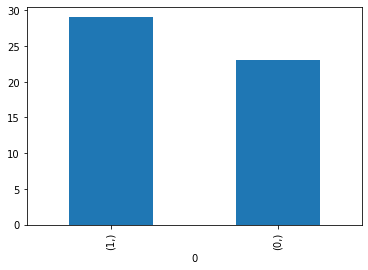

In [241]:
labels.value_counts().plot(kind='bar')

In [242]:
target_labels = pd.Series(data=labels.iloc[:, 0])


In [243]:

# Define the custom feature function 'distance'
@feature_calculators.set_property("fctype", "simple")
def distance(x):
    """
    Distance traveled in an axis

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: the value of this feature
    :return type: bool, int or float
    """
    # Distance traveled in one axis
    result = x.iloc[-1] - x.iloc[0]
    return result

# Add the custom feature function to the feature_calculators module
feature_calculators.__dict__['distance'] = distance

In [244]:
fc_parameters = {
                 'abs_energy':None, # Returns the absolute energy of the time series which is the sum over the squared values
                 'absolute_sum_of_changes':None, # Returns the sum over the absolute value of consecutive changes in the series x
                 #'fft_aggregated':[ #{'aggtype': 'centroid'}, # Returns the spectral centroid (mean), 
                  #                  {'aggtype': 'variance'}, # variance, 
                   #                 {'aggtype': 'skew'},     # skew, 
                    #                {'aggtype': 'kurtosis'}], # and kurtosis of the absolute fourier transform spectrum.
                 #'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}], # Uses c3 statistics to measure non linearity in the time series
                 'standard_deviation': None, # Returns the standard deviation of x
                 'variance': None, # Returns the variance of x
                 #'skewness': None, # Returns the sample skewness of x (calculated with the adjusted Fisher-Pearson standardized moment coefficient G1).
                 #'kurtosis': None, # Returns the kurtosis of x (calculated with the adjusted Fisher-Pearson standardized moment coefficient G2).
                 'maximum': None, # Calculates the highest value of the time series x.
                 'minimum': None, # Calculates the lowest value of the time series x.
                 #'sample_entropy':None, # Calculate and return sample entropy of x.
                 #'mean_abs_change':None, # Average over first differences.
                 #'sum_values':None, # Calculates the sum over the time series values
            #     'distance':None # Calculates the distance traveled in an axis
                }

In [245]:
X = extract_features(features, 
                     column_id="id", 
                     column_sort="time", 
                     default_fc_parameters=fc_parameters, 
                     impute_function=impute)

Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  9.42it/s]


In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, target_labels, test_size=0.2, random_state=42)

In [247]:
features_filtered_direct = select_features(X_train, 
                                           y_train,
                                           ml_task="classification", # Classification o regression, by default set to auto
                                           fdr_level = 0.5 # Respected percentage of features to be discarded as irrelevant, by default set to 0.05
                                          )

In [248]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Experience')
    plt.xlabel('Predicted Experience')

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0])

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.67      0.80         6

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



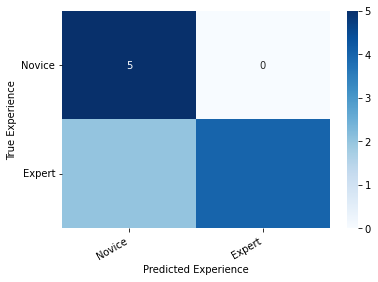

In [260]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(features_filtered_direct, y_train)
y_pred = DTC.predict(X_test[features_filtered_direct.columns])

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame( cm, index=['Novice', 'Expert'], columns=['Novice', 'Expert'])
show_confusion_matrix(df_cm)

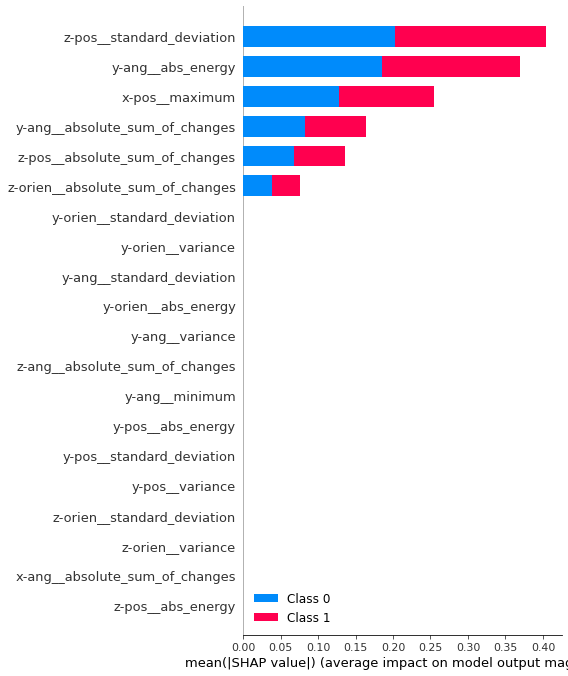

In [261]:
# Initialize a TreeExplainer object
explainer = shap.TreeExplainer(DTC)

# Generate SHAP values for the test dataset
shap_values = explainer.shap_values(features_filtered_direct)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, features_filtered_direct)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.67      0.80         6

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



  0%|          | 0/41 [00:00<?, ?it/s]

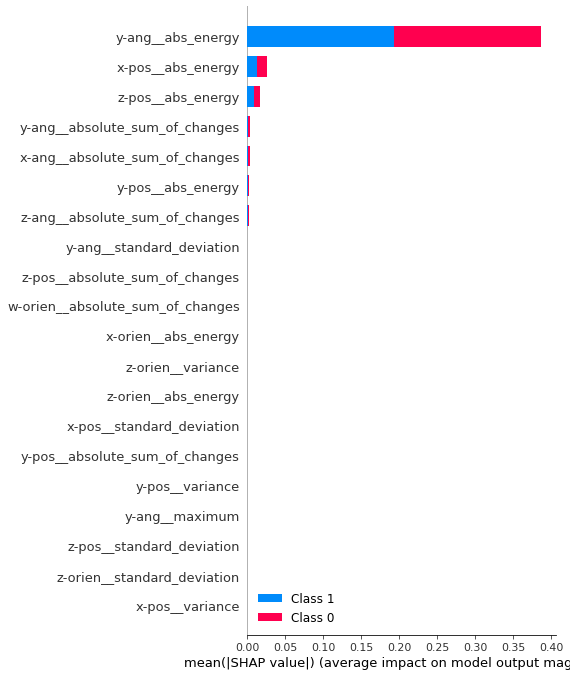

In [215]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(features_filtered_direct,y_train)
print(classification_report(y_test, DTC.predict(X_test[features_filtered_direct.columns])))

# Initialize a TreeExplainer object
explainer = shap.KernelExplainer(KNN.predict_proba, features_filtered_direct)

# Generate SHAP values for the test dataset
shap_values = explainer.shap_values(features_filtered_direct)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, features_filtered_direct)


              precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.67      0.33      0.44         6

    accuracy                           0.55        11
   macro avg       0.58      0.57      0.53        11
weighted avg       0.59      0.55      0.52        11



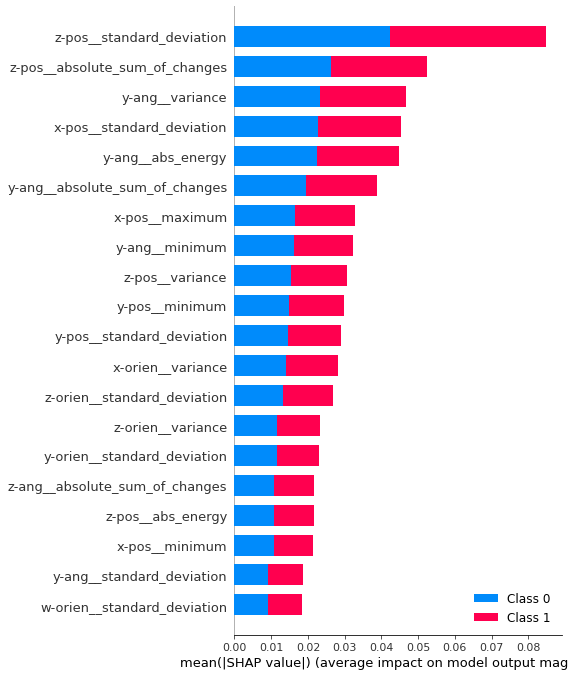

In [221]:
# Step 7: Train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=50, random_state=42)
classifier.fit(X_train, y_train)

# Step 8: Evaluate the classifier
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Initialize a TreeExplainer object
explainer = shap.TreeExplainer(classifier)

# Generate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test)

[LightGBM] [Info] Number of positive: 23, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 41, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560976 -> initscore=0.245122
[LightGBM] [Info] Start training from score 0.245122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

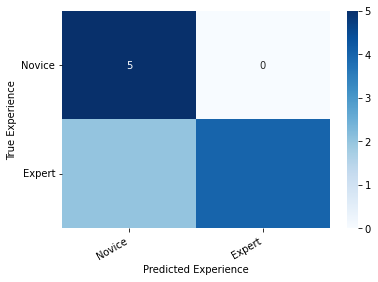

In [262]:
# Initialize the GBM model
gbm_model = lgb.LGBMClassifier()

# Fitting the model to the training data
gbm_model.fit(X_train, y_train)

y_pred = gbm_model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame( cm, index=['Novice', 'Expert'], columns=['Novice', 'Expert'])
show_confusion_matrix(df_cm)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


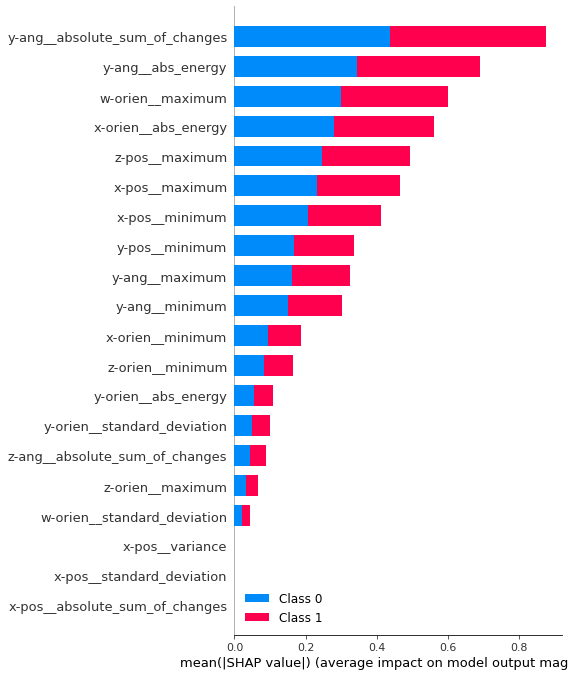

In [263]:
# Initialize a TreeExplainer object
explainer = shap.TreeExplainer(gbm_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)